In [ ]:
# pip install --upgrade torch

In [ ]:
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

In simple terms: The model learns vector representations for words by predicting their co-occurrence relationships as described by the matrix.

$$
J = \sum_{i,j} f(X_{ij}) \left( w_i^\top w_j + b_i + b_j - \log X_{ij} \right)^2
$$

The gap between the prediction and the target

$$
\left( w_i^\top w_j + b_i + b_j - \log X_{ij} \right)^2
$$

The weighting function that adjusts how much importance is given to each word pair (i,j) based on their co-occurrence frequency. The calculation is the amount of co-occurence / some hyperparameter (typically 10). The result is raised to the power of another hyper parameter, typically 0.75

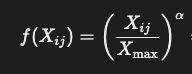

* Xmax -  limits the impact of very frequent co-occurrences, preventing them from dominating trainingabs
* alpha - balances the scaling of weights, giving less frequent pairs a fair impact without overemphasizing rare ones.

$$
f(X_{ij})
$$

In [ ]:
nltk.download("gutenberg")
nltk.download("punkt")

In [43]:
corpus = nltk.corpus.gutenberg.sents("austen-emma.txt")

corpus = [preprocess(sentence) for sentence in corpus]
tokenized_corpus = [sentence.split() for sentence in corpus]

[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Sample preprocessed sentence: [['emma', 'by', 'jane', 'austen']]


In [ ]:
def preprocess(sentence):
    sentence = " ".join(sentence).lower()  # Lowercase
    sentence = re.sub(r"[^a-z\s]", "", sentence)  # Remove punctuation
    return sentence

In [ ]:
vocab = set(word for sentence in tokenized_corpus for word in sentence)
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [49]:
%%time
# Build the co-occurrence matrix
window_size = 2
co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

for sentence in tokenized_corpus:
    for idx, word in enumerate(sentence):
        word_idx = word_to_idx[word]
        start = max(idx - window_size, 0)
        end = min(idx + window_size + 1, len(sentence))
        for context_word in sentence[start:end]:
            if context_word != word:
                context_idx = word_to_idx[context_word]
                co_occurrence_matrix[word_idx, context_idx] += 1

print("Co-occurrence matrix shape:", co_occurrence_matrix.shape)


Co-occurrence matrix shape: (7096, 7096)
CPU times: user 1.77 s, sys: 170 ms, total: 1.94 s
Wall time: 1.94 s


In [61]:
corpus[0]

' emma by jane austen  '

In [62]:
len(corpus)

7752

In [63]:
class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloVe, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)

        # Initialize weights
        nn.init.xavier_uniform_(self.word_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)
        nn.init.zeros_(self.word_biases.weight)
        nn.init.zeros_(self.context_biases.weight)

    def forward(self, word_idx, context_idx):
        word_embed = self.word_embeddings(word_idx)
        context_embed = self.context_embeddings(context_idx)
        word_bias = self.word_biases(word_idx).squeeze()
        context_bias = self.context_biases(context_idx).squeeze()
        
        # Dot product + biases
        prediction = (word_embed * context_embed).sum(dim=1) + word_bias + context_bias
        return prediction


In [93]:
import torch.nn as nn

class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloVe, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)

        # Initialize weights
        nn.init.uniform_(self.word_embeddings.weight, a=-0.5, b=0.5)  
        nn.init.uniform_(self.context_embeddings.weight, a=-0.5, b=0.5)
        nn.init.zeros_(self.word_biases.weight)
        nn.init.zeros_(self.context_biases.weight)

    def forward(self, word_idx, context_idx):
        word_embed = self.word_embeddings(word_idx)
        context_embed = self.context_embeddings(context_idx)
        word_bias = self.word_biases(word_idx).squeeze()
        context_bias = self.context_biases(context_idx).squeeze()
        
        # Dot product + biases
        prediction = (word_embed * context_embed).sum(dim=1) + word_bias + context_bias
        return prediction


In [94]:
def weighting_function(x, X_max=100, alpha=0.75):
    return torch.where(x < X_max, (x / X_max) ** alpha, torch.ones_like(x))

def glove_loss(prediction, log_co_occurrence, weights):
    return torch.sum(weights * (prediction - log_co_occurrence) ** 2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [119]:
co_occurrence = torch.tensor(co_occurrence_matrix, dtype=torch.float32, device=device)
log_co_occurrence = torch.log(co_occurrence + 1)

In [ ]:
t = torch.tensor([1, 1, 0, 0])
torch.nonzero(t)

In [120]:
# torch.nonzero is a PyTorch function that returns the indices of all non-zero elements in a tensor.
word_indices, context_indices = torch.nonzero(co_occurrence, as_tuple=True)
co_occurrence_values = co_occurrence[word_indices, context_indices]
weights = weighting_function(co_occurrence_values)

In [121]:
# Initialize model and optimizer
embedding_dim = 100
model = GloVe(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [122]:
# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(word_indices, context_indices)
    
    # Compute loss
    loss = glove_loss(predictions, log_co_occurrence[word_indices, context_indices], weights)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

print("Training complete!")

Epoch 10, Loss: 30280.5625
Epoch 20, Loss: 6990.6714
Epoch 30, Loss: 3633.1284
Epoch 40, Loss: 2244.1128
Epoch 50, Loss: 1368.1260
Epoch 60, Loss: 1028.3760
Epoch 70, Loss: 811.9969
Epoch 80, Loss: 670.2060
Epoch 90, Loss: 568.6556
Epoch 100, Loss: 492.0566
Training complete!


In [123]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman"), ("deep", "learning"), ("fun", "amazing")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")


Cosine Similarities:
Similarity between 'king' and 'queen': 0.0215
Similarity between 'man' and 'woman': 0.4022
Words 'deep' or 'learning' not in vocabulary.
Words 'fun' or 'amazing' not in vocabulary.


In [19]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman"), ("deep", "learning"), ("fun", "amazing")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")



Cosine Similarities:
Similarity between 'king' and 'queen': 0.3132
Similarity between 'man' and 'woman': 0.5327
Words 'deep' or 'learning' not in vocabulary.
Words 'fun' or 'amazing' not in vocabulary.


In [22]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")



Cosine Similarities:
Similarity between 'king' and 'queen': 0.3152
Similarity between 'man' and 'woman': 0.4924


$$
\begin{array}{|c|c|c|}
\hline
\textbf{Aspect} & \textbf{GloVe} & \textbf{Word2Vec} \\
\hline
\textbf{Training Approach} & \text{Uses a co-occurrence matrix and matrix factorization.} & \text{Predictive model using CBOW or Skip-Gram.} \\
\hline
\textbf{Data Utilization} & \text{Leverages entire corpus statistics for global context.} & \text{Processes word pairs iteratively in local contexts.} \\
\hline
\textbf{Training Efficiency} & \text{Slower due to large co-occurrence matrix decomposition.} & \text{Faster with a simpler predictive model.} \\
\hline
\textbf{Representation} & \text{Captures global semantic relationships.} & \text{Focuses on local contextual similarities.} \\
\hline
\textbf{Memory Usage} & \text{Requires more memory for storing a co-occurrence matrix.} & \text{Less memory-intensive with dynamic processing.} \\
\hline
\textbf{Performance} & \text{Excels in analogy and word similarity tasks.} & \text{Captures context-specific meanings better.} \\
\hline
\end{array}
$$


# Exercise

In [166]:
# !pip install spacy
# !python -m spacy download en_core_web_md

In [159]:
import spacy

# Load the English medium model with word vectors
nlp = spacy.load('en_core_web_md')

# Access word vectors
movie_vector = nlp('movie').vector
print(movie_vector)  # GloVe-like embedding for "movie"


[-2.3446    1.0975   -4.6895   -8.4208   -3.6353   -0.24038   6.6428
  1.6418    0.49773  -6.321     1.6186   -0.5861    0.63108  -0.24744
  0.29919  -3.8426    4.2843    2.1738    0.41612   3.1827    3.2224
  5.0443    0.72128  -4.7134   -4.0458    2.1136   -2.8936   -0.42879
 -0.69461   2.3631   -2.8901    4.7581    2.6114    1.0457   -1.6006
  3.7869   -1.0832    1.9244    0.38682  -3.2681   -2.7907   -1.8807
  0.2354    1.0458    3.4776   -1.1807   -3.6822   -4.3433    3.8024
  3.3623    0.24533   1.1       4.9555    0.17855  -4.2763   -1.8527
 -0.21801  -3.5733    2.3128    4.8652   -0.17878   2.6503   -3.8391
  1.5403   -0.26942   3.997    -9.1952   -2.2391   -3.4958   -2.4144
 -5.3832    2.3918   -5.2075   -3.3855    4.1362    0.6631    3.3512
  0.39198   1.0602    2.2332    1.4476    2.8263    5.2858   -1.015
  1.5394   -2.7863    4.6867    0.44141  -4.1558    2.8847   -4.1582
  6.9774    1.5895   -1.9002   -0.06736  -5.3914    4.8448   -2.7114
  1.5776    0.93064  -0.20705  -3

In [161]:
data = [
    ("I love this movie!", "positive"),
    ("This is the worst film I’ve ever seen.", "negative"),
    ("Absolutely fantastic experience.", "positive"),
    ("I hated it. Total waste of time.", "negative"),
    ("The plot was amazing and I enjoyed it a lot.", "positive"),
    ("Terrible acting and boring story.", "negative"),
]

In [162]:
# Create features (vectors) and labels
X = [nlp(text).vector for text, label in data]
y = [1 if label == "positive" else 0 for _, label in data]  # 1 = positive, 0 = negative

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Test the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5


In [164]:
new_sentences = [
    "This product is awesome!",
    "I regret buying this, such a disappointment.",
    "What a wonderful day."
]

for sentence in new_sentences:
    vector = nlp(sentence).vector
    prediction = clf.predict([vector])
    sentiment = "positive" if prediction[0] == 1 else "negative"
    print(f"Sentence: '{sentence}' -> Sentiment: {sentiment}")


Sentence: 'This product is awesome!' -> Sentiment: positive
Sentence: 'I regret buying this, such a disappointment.' -> Sentiment: positive
Sentence: 'What a wonderful day.' -> Sentiment: positive


In [2]:
from datasets import load_dataset

In [1]:
# Load Yelp polarity dataset
dataset = load_dataset("yelp_polarity")
# dataset = load_dataset("amazon_polarity")

# Split into train and test sets
train_data = dataset["train"]
test_data = dataset["test"]

NameError: name 'load_dataset' is not defined